# Parameter tests

The modeller `emg3d` has quite a few parameters which can influence the speed of a calculation. It can be difficult to estimate which is the best setting. In the case that speed is of utmost importance, and a lot of similar models are going to be calculated (e.g. for inversions), it might be worth to do some input parameter testing. Here some examples, for which we take the model from `1c_3D_triaxial_SimPEG`, and slightly alter it.

## IMPORTANT
**None of the conclusions you can draw from these figures are general. What is faster depends on your input. Influence has particularly the degree of anisotropy and of model stretching.**

**Requires:** `emg3d` >= 0.9.2

In [1]:
import emg3d
import discretize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
%matplotlib notebook
plt.style.use('ggplot')

## Plotting routine

In [3]:
def plotit(infos, labels):

    plt.figure()
    
    for i, info in enumerate(infos):
        plt.plot(info['runtime_at_cycle'],
                 info['error_at_cycle']/info1['ref_error'],
                 '.-', label=labels[i])
        
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Rel. Error $(-)$')
    plt.yscale('log')
    
    plt.show()

## Create inputs

### Mesh and source-field

In [4]:
# Create mesh
grid = discretize.TensorMesh(
    [[(100, 12, -1.05), (100, int(4000/100)), (100, 12, 1.05)], 
     [(100, 12, -1.05), (100, int(4000/100)), (100, 12, 1.05)], 
     [(100, 9, -1.15), (100, int(-1400/100)), (100, 9, 1.15)]]
)

# Center mesh
grid.x0 = np.r_[-grid.hx.sum()/2, -grid.hy.sum()/2, -grid.hz[:-9].sum()]

# Create the source field for this mesh and given frequency
sfield = emg3d.utils.get_source_field(grid, src=[-100, 100, 0, 0, -900, -900], freq=1.0, strength=0)

# We take the receiver locations at the actual CCx-locations
rec_x = grid.vectorCCx[12:-12]

### Create model

In [5]:
# Layered_background
res_x = 1e8*np.ones(grid.nC)
res_x[grid.gridCC[:, 2] <= 0] = 0.3

res_y = res_x.copy()
res_z = res_x.copy()

res_x[grid.gridCC[:, 2] <= -1000] = 1.
res_y[grid.gridCC[:, 2] <= -1000] = 2.
res_z[grid.gridCC[:, 2] <= -1000] = 3.

# Include the target
target_inds = (
    (grid.gridCC[:, 0] >= -500) & (grid.gridCC[:, 0] <= 500) &
    (grid.gridCC[:, 1] >= -500) & (grid.gridCC[:, 1] <= 500) &
    (grid.gridCC[:, 2] >= -1400) & (grid.gridCC[:, 2] <= -1100)
)
res_x[target_inds] = 100
res_y[target_inds] = 100
res_z[target_inds] = 100

# Create emg3d-models for given frequency
model_iso = emg3d.utils.Model(grid, res_x)
model_aniso = emg3d.utils.Model(grid, res_x, res_y, res_z)

## Test 1: F, W, and V MG cycles

In [6]:
input = {'grid': grid, 'model': model_iso, 'sfield': sfield, 'verb': -1, 'return_info': True}
_, info1 = emg3d.solver.solver(cycle='F', **input)
_, info2 = emg3d.solver.solver(cycle='W', **input)
_, info3 = emg3d.solver.solver(cycle='V', **input)

:: emg3d :: 8.6e-07; 21; 0:00:08; CONVERGED
:: emg3d :: 8.6e-07; 21; 0:00:09; CONVERGED
:: emg3d :: 8.6e-07; 21; 0:00:06; CONVERGED


<IPython.core.display.Javascript object>


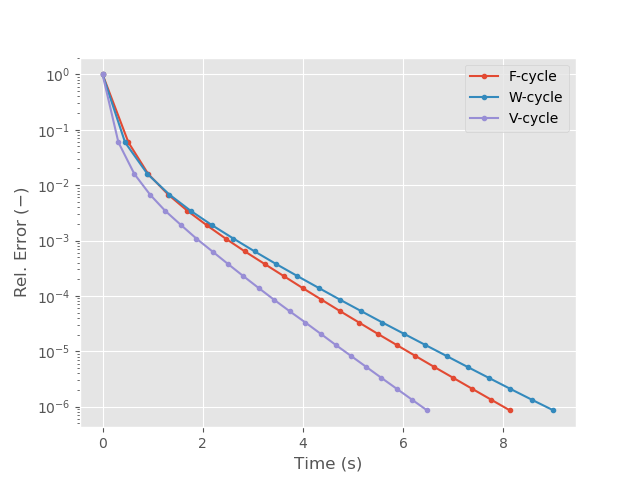

In [7]:
plotit([info1, info2, info3], ['F-cycle', 'W-cycle', 'V-cycle'])

## Test 2: semicoarsening, line-relaxation

In [8]:
input = {'grid': grid, 'model': model_aniso, 'sfield': sfield, 'verb': -1, 'return_info': True}
_, info1 = emg3d.solver.solver(**input)
_, info2 = emg3d.solver.solver(semicoarsening=True, **input)
_, info3 = emg3d.solver.solver(linerelaxation=True, **input)
_, info4 = emg3d.solver.solver(semicoarsening=True, linerelaxation=True, **input)

:: emg3d :: 9.2e-07; 40; 0:00:18; CONVERGED
:: emg3d :: 8.2e-08; 9; 0:00:05; CONVERGED
:: emg3d :: 8.4e-07; 15; 0:00:13; CONVERGED
:: emg3d :: 4.5e-08; 6; 0:00:08; CONVERGED


<IPython.core.display.Javascript object>


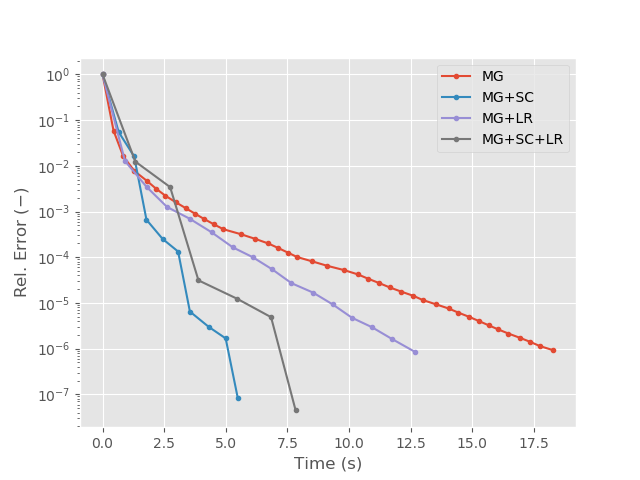

In [9]:
plotit([info1, info2, info3, info4], ['MG', 'MG+SC', 'MG+LR', 'MG+SC+LR'])

## Test 3: MG and BiCGstab

In [10]:
input = {'grid': grid, 'model': model_aniso, 'sfield': sfield, 'semicoarsening': True,
         'verb': -1, 'return_info': True, 'maxit': 500}
_, info1 = emg3d.solver.solver(cycle='F', sslsolver=False, **input)
_, info2 = emg3d.solver.solver(cycle='F', sslsolver=True, **input)
_, info3 = emg3d.solver.solver(cycle=None, sslsolver=True, **input)

:: emg3d :: 8.2e-08; 9; 0:00:06; CONVERGED
:: emg3d :: 7.1e-07; 2(8); 0:00:05; CONVERGED
:: emg3d :: 9.9e-07; 277(0); 0:00:10; CONVERGED


<IPython.core.display.Javascript object>


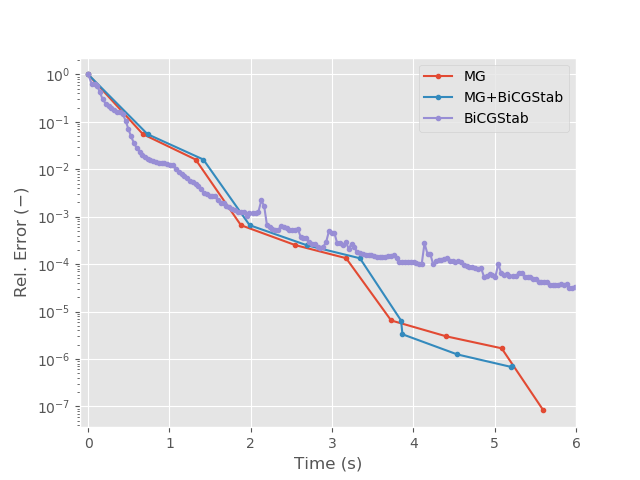

(-0.1, 6)

In [11]:
plotit([info1, info2, info3], ['MG', 'MG+BiCGStab', 'BiCGStab'])
plt.gcf().get_axes()[0].set_xlim([-.1,6])

## Test 4: `nu_init`, `nu_pre`, `nu_coarse`, `nu_post`

In [12]:
input = {'grid': grid, 'model': model_aniso, 'sfield': sfield, 'semicoarsening': True,
         'verb': -1, 'return_info': True}
_, info1 = emg3d.solver.solver(**input)
_, info2 = emg3d.solver.solver(nu_pre=0, **input)
_, info3 = emg3d.solver.solver(nu_post=0, **input)
_, info4 = emg3d.solver.solver(nu_init=2, **input)

:: emg3d :: 8.2e-08; 9; 0:00:05; CONVERGED
:: emg3d :: 1.4e-07; 12; 0:00:04; CONVERGED
:: emg3d :: 4.9e-07; 12; 0:00:04; CONVERGED
:: emg3d :: 6.2e-08; 9; 0:00:06; CONVERGED


<IPython.core.display.Javascript object>


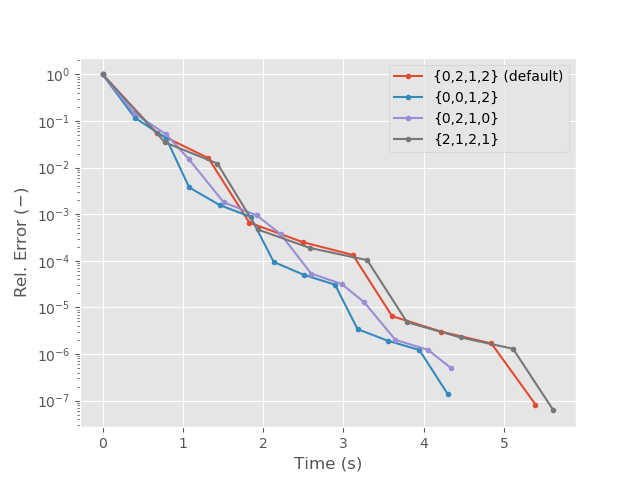

In [13]:
plotit([info1, info2, info3, info4], ['{0,2,1,2} (default)', '{0,0,1,2}', '{0,2,1,0}', '{2,1,2,1}'])

In [14]:
emg3d.Report(discretize)

--------------------------------------------------------------------------------
  Date: Thu Dec 26 13:15:18 2019 CET

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.5 GB : RAM
           Jupyter : Environment

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

            0.4.10 : discretize
            1.17.3 : numpy
             1.3.1 : scipy
            0.46.0 : numba
             0.9.2 : emg3d
             7.9.0 : IPython
             3.1.1 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------